In [1]:
import mxnet as mx
%matplotlib inline
import os
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import tarfile

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
data = np.random.rand(100,3)
label = np.random.randint(0, 10, (100,))
data_iter = mx.io.NDArrayIter(data=data, label=label, batch_size=30)
for batch in data_iter:
    print([batch.data, batch.label, batch.pad])

[[<NDArray 30x3 @cpu(0)>], [<NDArray 30 @cpu(0)>], 0]
[[<NDArray 30x3 @cpu(0)>], [<NDArray 30 @cpu(0)>], 0]
[[<NDArray 30x3 @cpu(0)>], [<NDArray 30 @cpu(0)>], 0]
[[<NDArray 30x3 @cpu(0)>], [<NDArray 30 @cpu(0)>], 20L]


In [3]:
np.savetxt('data.csv', data, delimiter=',')
data_iter = mx.io.CSVIter(data_csv='data.csv', data_shape=(3, ), batch_size=30)
for batch in data_iter:
    print([batch.data, batch.pad])

[[<NDArray 30x3 @cpu(0)>], 0]
[[<NDArray 30x3 @cpu(0)>], 0]
[[<NDArray 30x3 @cpu(0)>], 0]
[[<NDArray 30x3 @cpu(0)>], 20]


In [4]:
data

array([[ 0.92310264,  0.92971989,  0.19405368],
       [ 0.79006345,  0.97689292,  0.2549959 ],
       [ 0.54567677,  0.89876931,  0.00882215],
       [ 0.8436129 ,  0.25778715,  0.39782282],
       [ 0.29359009,  0.45101983,  0.19026079],
       [ 0.55654298,  0.61734274,  0.69093856],
       [ 0.67524418,  0.73501118,  0.45781338],
       [ 0.39532468,  0.16250396,  0.25693006],
       [ 0.90104797,  0.58841158,  0.13597393],
       [ 0.20363   ,  0.86084968,  0.52575768],
       [ 0.48256939,  0.60049639,  0.68840365],
       [ 0.71016751,  0.63226293,  0.33169114],
       [ 0.69763071,  0.36091677,  0.84548393],
       [ 0.69892926,  0.41266582,  0.67610837],
       [ 0.18094802,  0.34550597,  0.68530572],
       [ 0.65561348,  0.19255093,  0.81396271],
       [ 0.88929304,  0.38060635,  0.65496988],
       [ 0.06255451,  0.85927321,  0.80751723],
       [ 0.09053666,  0.23913992,  0.20528589],
       [ 0.8762051 ,  0.02294442,  0.87490519],
       [ 0.76549744,  0.38394812,  0.619

### Custom Iterator

**An Iterator in MXNet should:**
* Implement next() in Python2 or __next()__ in Python3
* eturning a DataBatch or raising a StopIteration exception if at the end of the data stream.
* Implement the reset() method to restart reading from the beginning.
* Have a provide_data attribute, consisting of a list of DataDesc objects that store the name, shape, type and layout information of the data.
* Have a provide_label attribute consisting of a list of DataDesc objects that store the name, shape, type and layout information of the label.

#### Example

In [5]:
class SimpleIter(mx.io.DataIter):
    def __init__(self, data_names, data_shapes, data_gen, label_names,
                label_shapes, label_gen, num_batches=10):
        self._provide_data = zip(data_names, data_shapes)
        self._provide_label = zip(label_names, label_shapes)
        self.num_batches = num_batches
        self.data_gen = data_gen
        self.label_gen = label_gen
        self.cur_batch = 0
        
    def __iter__(self):
        return self
    
    def reset(self):
        self.cur_batch = 0
        
    def __next__(self):
        return self.next()
    
    @property
    def provide_data(self):
        return self._provide_data
    
    @property
    def provide_label(self):
        return self._provide_label
    
    def next(self):
        if self.cur_batch < self.num_batches:
            self.cur_batch += 1
            data = [mx.nd.array(g(d[1])) for d, g in zip(self._provide_data, self.data_gen)]
            label = [mx.nd.array(g(d[1])) for d, g in zip(self._provide_label, self.label_gen)]
            return mx.io.DataBatch(data, label)
        else:
            raise StopIteration

then use teh above defined `SimpleIter` to train a simple Multi-layer
Perceptron program below:


In [6]:
num_classes = 10
net = mx.sym.Variable('data')
net = mx.sym.FullyConnected(data=net, name='fc1', num_hidden=64)
net = mx.sym.Activation(data=net, name='relu1', act_type='relu')
net = mx.sym.FullyConnected(data=net, name='fc2', num_hidden=num_classes)
net = mx.sym.SoftmaxOutput(data=net, name='softmax')
print (net.list_arguments())
print (net.list_outputs())

['data', 'fc1_weight', 'fc1_bias', 'fc2_weight', 'fc2_bias', 'softmax_label']
['softmax_output']


In [8]:
import logging
logging.basicConfig(level=logging.INFO)

n = 32
data_iter = SimpleIter(['data'], [(n, 100)],
                      [lambda s: np.random.uniform(-1, 1, s)],
                      ['softmax_label'], [(n, )],
                      [lambda s: np.random.randint(0, num_classes, s)])
mod = mx.mod.Module(symbol=net)
mod.fit(data_iter, num_epoch=5)

INFO:root:Epoch[0] Train-accuracy=0.118750
INFO:root:Epoch[0] Time cost=0.017
INFO:root:Epoch[1] Train-accuracy=0.093750
INFO:root:Epoch[1] Time cost=0.012
INFO:root:Epoch[2] Train-accuracy=0.103125
INFO:root:Epoch[2] Time cost=0.011
INFO:root:Epoch[3] Train-accuracy=0.093750
INFO:root:Epoch[3] Time cost=0.013
INFO:root:Epoch[4] Train-accuracy=0.109375
INFO:root:Epoch[4] Time cost=0.013


### MXRecordIO

In [9]:
record = mx.recordio.MXRecordIO('tmp.rec', 'w')
for i in range(5):
    record.write('record_%d'%i)
record.close()

In [10]:
record

In [11]:
record = mx.recordio.MXRecordIO('tmp.rec', 'r')
while True:
    item = record.read()
    if not item:
        break
    print (item)
record.close()

record_0
record_1
record_2
record_3
record_4


In [12]:
record =  mx.recordio.MXIndexedRecordIO('tmp.idx', 'tmp.rec', 'w')
for i in range(5):
    record.write_idx(i, 'record_%d'%i)
record.close()

In [13]:
record = mx.recordio.MXIndexedRecordIO('tmp.idx', 'tmp.rec', 'r')
record.read_idx(3)

'record_3'

In [14]:
record.keys

[0, 1, 2, 3, 4]

In [15]:
record.close()

#### MXNet recordio package privede Packing/Unpacking Binary Data

In [16]:
# Pack/Unpack are used for storing 
# 1. float(or 1d array of float) label 
# + 2. binary data
# The data is packed along with a header

# Pack
data = 'data'
label1 = 1.0
header1 = mx.recordio.IRHeader(flag=0, label=label1, id=1, id2=0)
s1 = mx.recordio.pack(header1, data)

label2 = [1.0, 2.0, 3.0]
header2 = mx.recordio.IRHeader(flag=3, label=label2, id=2, id2=0)
s2 = mx.recordio.pack(header2, data)

In [17]:
# Unpack
print(mx.recordio.unpack(s1))
print(mx.recordio.unpack(s2))

(HEADER(flag=0, label=1.0, id=1, id2=0), 'data')
(HEADER(flag=3, label=array([ 1.,  2.,  3.], dtype=float32), id=2, id2=0), 'data')


#### MXNet recordio package privede Packing/Unpacking Image Data

In [18]:
# pack_img
data = np.ones((3,3,1), dtype=np.uint8)
label = 1.0
header = mx.recordio.IRHeader(flag=0, label=label, id=0, id2=0)
s = mx.recordio.pack_img(header, data, quality=100, img_fmt='.jpg')

In [19]:
# unpack_img
print(mx.recordio.unpack_img(s))

(HEADER(flag=0, label=1.0, id=0, id2=0), array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]], dtype=uint8))


#### Use tools/im2rec.py to convert raw images into RecordIO format

### Image IO
there are 4 ways of loading image data in MXNet
1. Using mx.image.imdecode to load raw image files.
2. Using mx.img.ImageIter, it can read from .rec(RecordIO) files and raw image files
3. Using mx.io.ImageRecordIter, it is less flexible to customization but provides various language bindings
4. Create a Custom Iterator inheriting mx.io.DataIter

#### Preprocessing images
* Using mx.io.ImageRecordIter which is fast but not very flexible.
* Using mx.recordio.unpack_img(or cv2.imread, skimage) + numpy is flexible but slow due to Python Global INterpreter Lock (GIL)
* Using MXNet provided mx.image package. It stores images in NDArray format and leveerages MXNet's dependency engine to automatically parallelize processing and circumvent GIL.

In [22]:
import mxnet as mx
import tarfile as tar
fname = mx.test_utils.download(url='http://data.mxnet.io/data/test_images.tar.gz', dirname='data', overwrite=False)
tar = tarfile.open(fname)
tar.extractall(path='./data')
tar.close()

INFO:root:create directory data
INFO:root:downloaded http://data.mxnet.io/data/test_images.tar.gz into data/test_images.tar.gz successfully


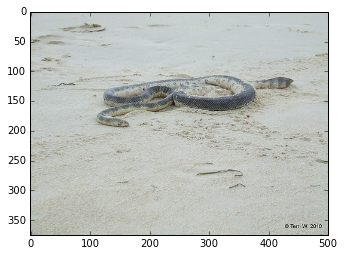

In [23]:
img = mx.image.imdecode(open('data/test_images/ILSVRC2012_val_00000001.JPEG').read())
plt.imshow(img.asnumpy());
plt.show()

In [24]:
img

<NDArray 375x500x3 @cpu(0)>

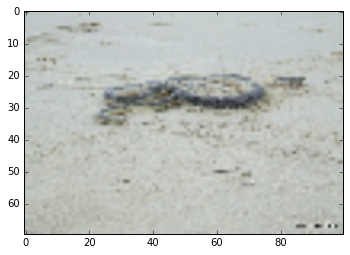

In [25]:
tmp = mx.image.imresize(img, 100, 70)
plt.imshow(tmp.asnumpy())
plt.show()

(13, 115, 150, 200)


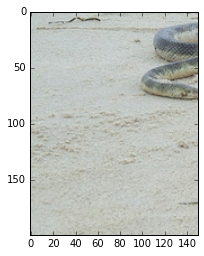

In [26]:
tmp, coord = mx.image.random_crop(img, (150, 200))
print(coord)
plt.imshow(tmp.asnumpy())
plt.show()

### Get a sample Caltech 101 dataset that contains 101 classes of objects
### then convert tehm into record io format.

In [ ]:
fname = mx.test_utils.download(url='http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz', dirname='data', overwrite=True)
tar = tarfile.open(fname)
tar.extractall(path='./data')
tar.close()

In [ ]:
os.system('python %s/tools/im2rec.py --list=1 --recursive=1 --shuffle=1 --test-ratio=0.2 data/caltech data/101_ObjectCategories'%MXNET_HOME)